In [6]:
#calcuting ekman pumping from wind stress
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
"""
f = 2 omega sin phi

omega = 2pi radians/day

f = 4 pi radians/day sin phi

ekman = 1/rho f (dtauy/dx - dtaux/dy)
"""

'\nf = 2 omega sin phi\n\nomega = 2pi radians/day\n\nf = 4 pi radians/day sin phi\n\nekman = 1/rho f (dtauy/dx - dtaux/dy)\n'

In [8]:
def coriolis_param(lat):
    day = (24*60*60)-(4*60)# this is 23hrs 56mins
    om = (2*np.pi)/day
    f = 2*om*np.sin(lat * np.pi / 180)
    return f

In [9]:
def ekman(taux, tauy):
    rho = 1026#kgm^-3
    f = coriolis_param(taux.lat)
    dtydx = tauy.differentiate('lon') / (110e3 * np.cos(tauy.lat * np.pi / 180))
    dtxdy = taux.differentiate('lat') / (110e3)
    ek = (1/(rho*f))*(dtydx-dtxdy)
    return ek

In [19]:
#ekman layer depth formualr
def eld(uwnd, vwnd):
    U10 = np.sqrt((uwnd**2) + (vwnd**2))
    DE = (7.6/np.sqrt(np.sin(abs(uwnd.lat* np.pi / 180)))) * U10
    return DE

In [20]:
uw = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/VAS/vas*.nc').vas.sel(lat=slice(-40,30),lon=slice(30,125))
vw = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/VAS/uas*.nc').uas.sel(lat=slice(-40,30),lon=slice(30,125))


In [21]:
testED = eld(uw, vw)

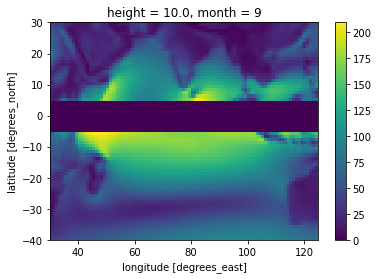

In [28]:
testED.where((testED.lat<-5)|(testED.lat>5), 0).groupby('time.month').mean('time')[:,8].plot()

In [8]:
#load in data
tauu= xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/uflx/*.nc').uflx.sel(lat=slice(-40,30),lon=slice(30,125))
tauv= xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/vflx/*.nc').vflx.sel(lat=slice(-40,30),lon=slice(30,125))


In [10]:
#set nan to 0
tauu1 = tauu.fillna(0)
tauv1 = tauv.fillna(0)

In [11]:
Wek = ekman(tauu1, tauv1)

In [13]:
Wek_ = Wek.groupby('time.month').mean('time')

In [21]:
#mask band of equator
Wek_ = Wek_.where((Wek_.lat<-5)|(Wek_.lat>5), 0)

In [22]:
#now plot climatology
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -30., 20.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 5:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
def plot_var(vari, vmin, vmax, name):
    lons = vari.lon
    lats = vari.lat
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 15), sharey='all', sharex='all', 
                                 subplot_kw={'projection':ccrs.PlateCarree()})
    for i in range(0,6):

        axes[i, 0].pcolormesh(lons, lats, (vari).sel(month = i+1), cmap = 'RdBu_r', 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,0], i, 0)
        mon = i+1
        axes[i, 0].set_title('Month = '+str(mon))
        #2nd collumn
        im = axes[i, 1].pcolormesh(lons, lats, (vari).sel(month = i+7), cmap = 'RdBu_r', 
                                    #colorbar=True, 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,1], i, 1)
        mon2 = i+7
        axes[i, 1].set_title('Month = '+str(mon2))
    cbar_ax = fig.add_axes([0.95, 0.45, 0.05, 0.25])
    fig.colorbar(im, cax=cbar_ax)
    axes[0,0].text(1.5,1.3, name, va='bottom', ha='center', fontsize = 'x-large',
            rotation='horizontal', rotation_mode='anchor',
            transform=axes[0,0].transAxes)
    return fig

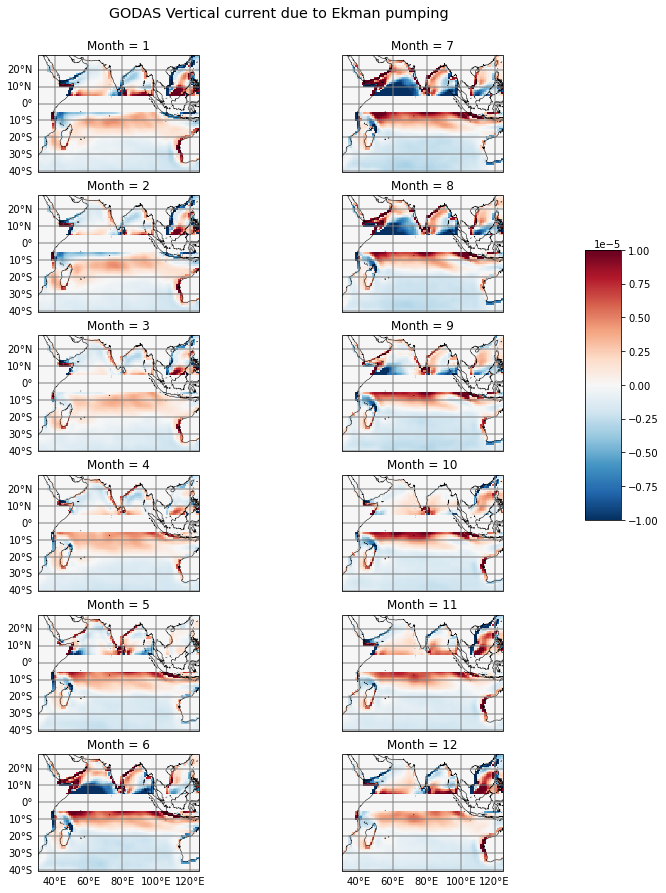

In [24]:
a = plot_var(Wek_, -1e-5, 1e-5, 'GODAS Vertical current due to Ekman pumping')
a.savefig('/home/z5113258/Documents/figures/GODAS_EKMAN.png', dpi = 300, bbox_inches='tight')